## ALE Detection for WSN
This data set is intended for regression with machine learning algorithms in order to predict average localized error (ALE) in wireless sensor networks (WSN). This is a simple regression project, so I will not have lots of comments.

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
from numpy import array
import re
import numpy as np

df = pd.read_csv('./data/mcs_ds_edited_iter_shuffled.csv')
df.sort_values("ale", axis=0)
df.head()


,anchor_ratio,trans_range,node_density,iterations,ale,sd_ale
0,30,15,200,40,0.773546,0.250555
1,15,15,100,70,0.911941,0.498329
2,30,15,100,50,0.814867,0.255546
3,15,20,100,20,1.435332,0.394603
4,30,15,100,40,1.265909,0.302943


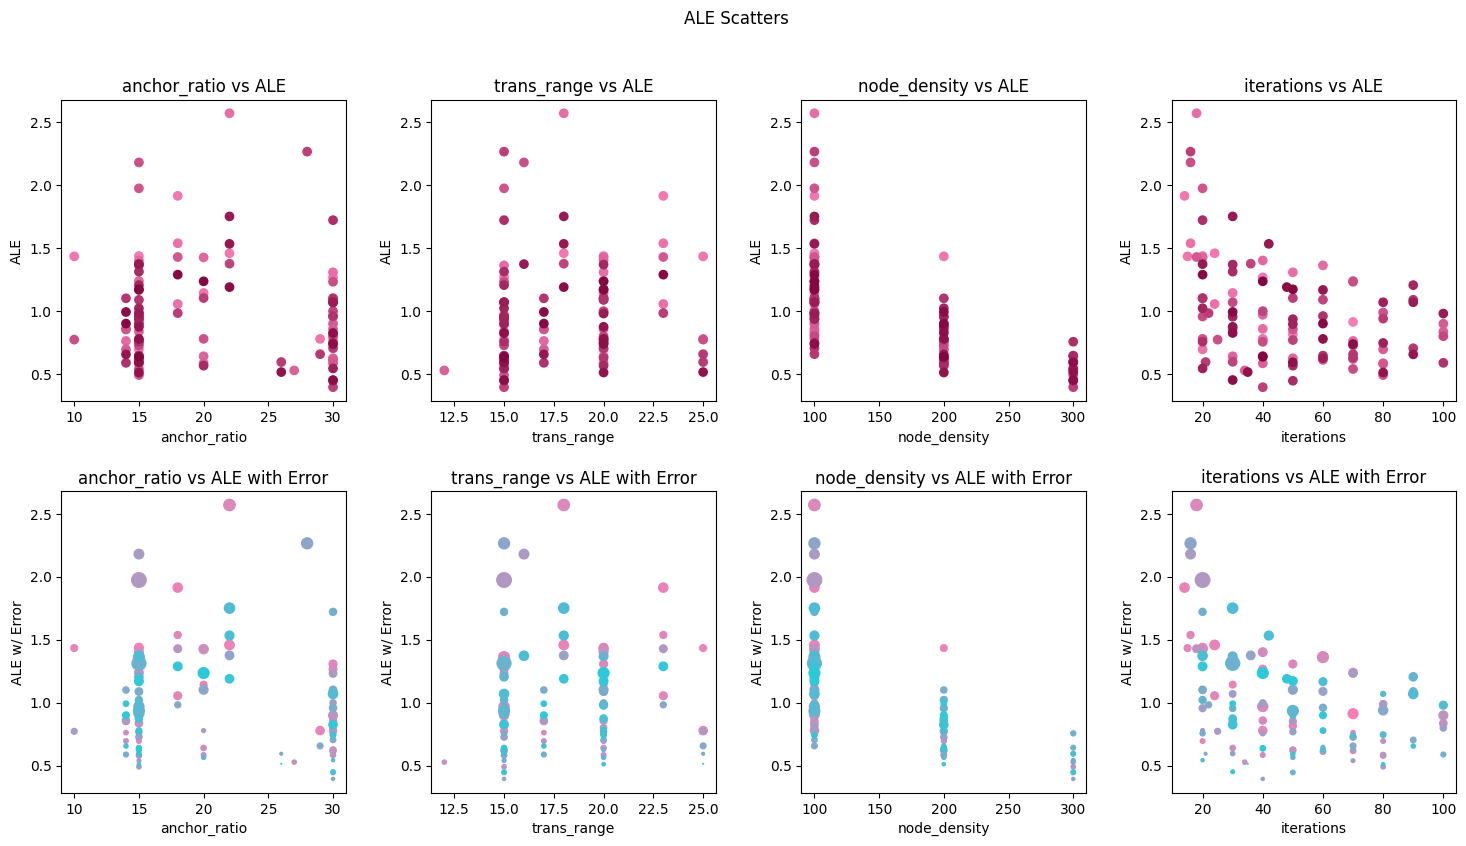

In [5]:
plt.figure(figsize=(18,9))
plt.suptitle("ALE Scatters")
plt.subplots_adjust(hspace=0.3, wspace=0.3)
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def color_gradient(valuelist, c1, c2):
    maxval = max(valuelist)
    minval = min(valuelist)
    r = maxval - minval #range
    c1_rgb = array(hex_to_RGB(c1))/255
    c2_rgb = array(hex_to_RGB(c2))/255
    mix_pcts = [x/(len(valuelist)-1) for x in range(len(valuelist))]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]



colors = color_gradient(df["ale"], "#f77eb5", "#85053f")

for color in colors:
    j = re.search(r'^#(?:[0-9a-fA-F]{3}){1,2}$', color)
    if j == None:
        print(f'{color} is failing')

for axis, column in enumerate(df.columns):
    if column == 'ale':
        break
    sub = plt.subplot(2,4, axis + 1)
    sub.scatter(df[column], df["ale"], c=colors)
    sub.set_title(f'{column} vs ALE')
    sub.set_ylabel("ALE")
    sub.set_xlabel(column)

colors = color_gradient(df["ale"], "#f77eb5", "#2acadb")

for axis, column in enumerate(df.columns):
    if column == 'ale':
        break
    sub = plt.subplot(2,4, axis + 5)
    sub.scatter(df[column], df["ale"], s=df["sd_ale"]*100, c=colors) #Mutltiply by 100 so the error is easier to see
    sub.set_title(f'{column} vs ALE with Error')
    sub.set_ylabel("ALE w/ Error")
    sub.set_xlabel(column)




In [6]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split


y = df['ale']
x = df.drop(["ale", "sd_ale"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=26)

a=0.1

lassomodel = Lasso(alpha=a)
ridgemodel = Ridge(alpha=a)
lassomodel.fit(x_train, y_train)
ridgemodel.fit(x_train, y_train)
print(f'Lasso Model at {lassomodel.score(x_test, y_test)}')
print(f'Ridge Model at {ridgemodel.score(x_test, y_test)}')


Lasso Model at 0.7082311767845593
Ridge Model at 0.744859322316098


In [7]:
avals = [0.1 + 0.05*r for r in range(19)]
splits = [0.05 + 0.05*r for r in range(19)]
alphascores = [[[],[]] for i in range(19)]
splitscores = [[[],[]] for i in range(19)]
for col, split in enumerate(splits):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split, random_state=26)
    for place, a in enumerate(avals):
        lassomodel = Lasso(alpha=a)
        ridgemodel = Ridge(alpha=a)
        lassomodel.fit(x_train, y_train)
        ridgemodel.fit(x_train, y_train)
        alphascores[place][0].append(ridgemodel.score(x_test, y_test))
        alphascores[place][1].append(lassomodel.score(x_test, y_test))
        splitscores[col][0].append(ridgemodel.score(x_test, y_test))
        splitscores[col][1].append(lassomodel.score(x_test, y_test))



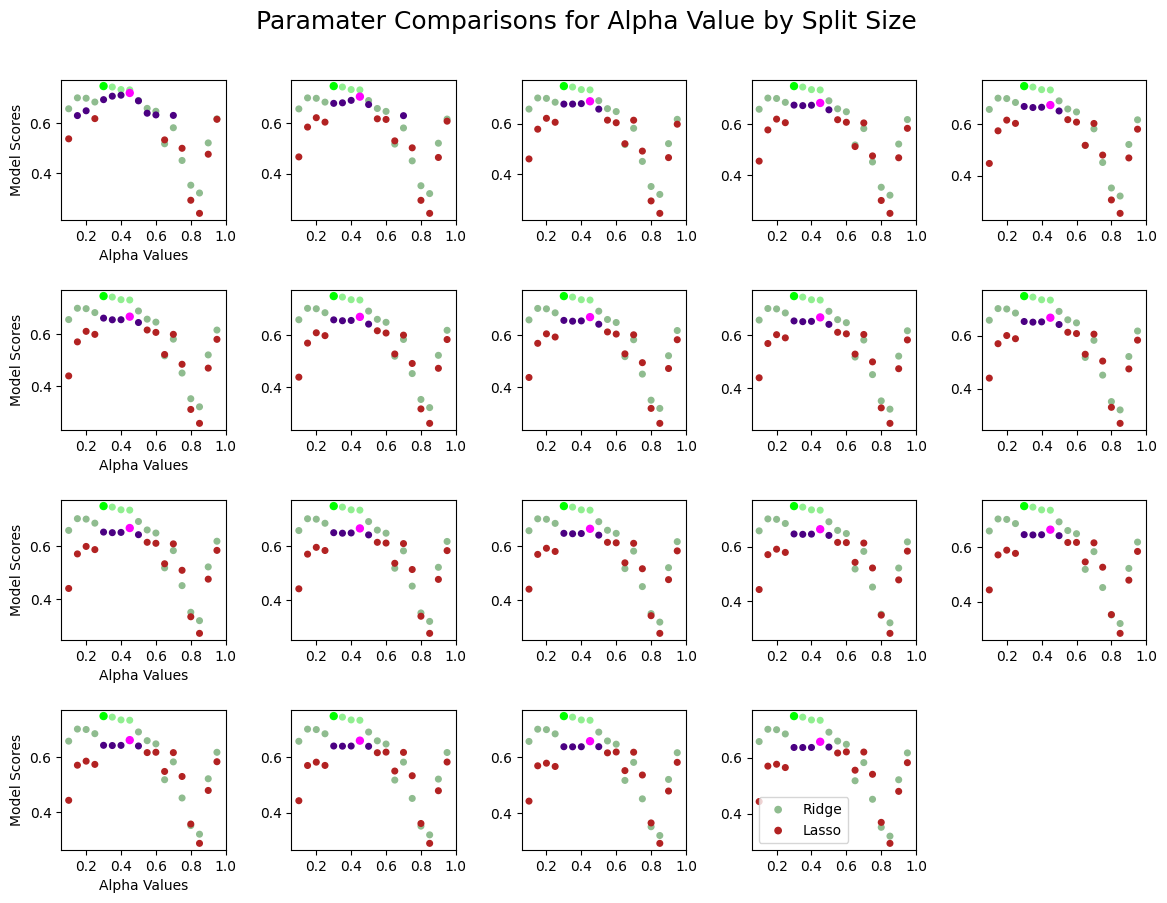

In [8]:
plt.figure(figsize=(14, 10))
colorkeyridge = lambda score, lister: 'lime' if score == max(lister) else 'lightgreen' if score > 0.725 else 'darkseagreen' 
colorkeylasso = lambda score, lister: 'magenta' if score == max(lister) else 'indigo' if score > 0.63 else 'firebrick'
sizekey = lambda score, lister: 25 if score == max(lister) else 16.5
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.suptitle("Paramater Comparisons for Alpha Value by Split Size", fontsize=18, y=0.95)
for axis, alpha in enumerate(alphascores):
    alpha[0].pop() #Last one is negative so we want to remove it as it messes with the graphs
    alpha[1].pop()
    y_alpha_ridge = alpha[0]
    y_alpha_lasso = alpha[1]
    sub = plt.subplot(4,5, axis+1)
    sub.scatter(avals[:-1], y_alpha_ridge, c=[colorkeyridge(score, y_alpha_ridge) for score in y_alpha_ridge], s=[sizekey(score, y_alpha_ridge) for score in y_alpha_ridge])
    sub.scatter(avals[:-1], y_alpha_lasso, c=[colorkeylasso(score, y_alpha_lasso) for score in y_alpha_lasso], s=[sizekey(score, y_alpha_lasso) for score in y_alpha_lasso])
    sub.set_xticks([0.2 + 0.2*s for s in range(5)])

    if axis % 5 == 0:
        sub.set_xlabel('Alpha Values')
        sub.set_ylabel('Model Scores')

plt.legend(['Ridge', "Lasso"])
plt.show() # While these may not bee the prettiest graphs, I think it's easy to see which scatter belongs to whom and where the max values are.


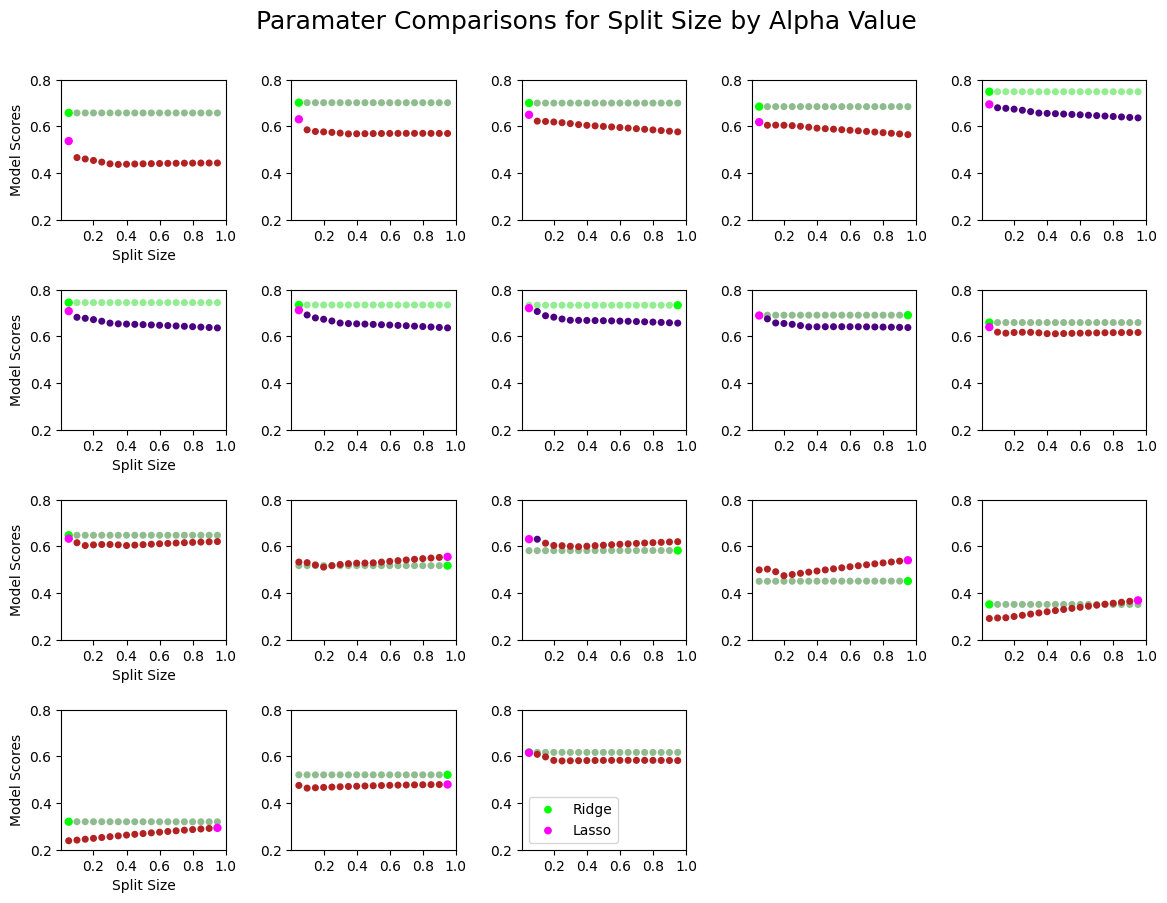

In [9]:
plt.figure(figsize=(14, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.suptitle("Paramater Comparisons for Split Size by Alpha Value", fontsize=18, y=0.95)
if len(splitscores) == 19:
    splitscores.pop()
for axis, alpha in enumerate(splitscores):
    y_alpha_ridge = alpha[0]
    y_alpha_lasso = alpha[1]
    sub = plt.subplot(4,5, axis+1)
    sub.scatter(splits, y_alpha_ridge, c=[colorkeyridge(score, y_alpha_ridge) for score in y_alpha_ridge], s=[sizekey(score, y_alpha_ridge) for score in y_alpha_ridge])
    sub.scatter(splits, y_alpha_lasso, c=[colorkeylasso(score, y_alpha_lasso) for score in y_alpha_lasso], s=[sizekey(score, y_alpha_lasso) for score in y_alpha_lasso])
    sub.set_xticks([0.2 + 0.2*s for s in range(5)])
    sub.set_ybound(0.2,0.8)

    if axis % 5 == 0:
        sub.set_xlabel('Split Size')
        sub.set_ylabel('Model Scores')

plt.legend(['Ridge', "Lasso"])
plt.show()


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=26)
finalmodel = Ridge(alpha=0.3)
finalmodel.fit(x_train, y_train)
print(f'Final Score is at {finalmodel.score(x_test, y_test)} for linear regression.')

Final Score is at 0.748637663491478 for linear regression.
